# Import library

Link of data field: https://q-shick.github.io/portfolio/proj_hmda.html

In [1]:
# dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans, DBSCAN
import scipy.cluster.hierarchy as shc

# model preparation
from sklearn import preprocessing as ppr
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# modeling
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier   
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

# model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

In [2]:
FILE_PATH = "../data/"
FILE_NAME = FILE_PATH + "state_NY-CA.csv"

# Load dataset and first looking

In [3]:
df = pd.read_csv(FILE_NAME)

# Display basic information about the dataset
print("Dataset Overview:")
print(df.info())

/tmp/ipykernel_9399/1955382456.py:1: DtypeWarning: Columns (5,22,23,24,26,27,28,29,30,31,32,33,38,43,44,46,77,78,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_NAME)


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337463 entries, 0 to 1337462
Data columns (total 99 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   activity_year                             1337463 non-null  int64  
 1   lei                                       1337463 non-null  object 
 2   derived_msa-md                            1337463 non-null  int64  
 3   state_code                                1337463 non-null  object 
 4   county_code                               1327993 non-null  float64
 5   census_tract                              1324599 non-null  object 
 6   conforming_loan_limit                     1328209 non-null  object 
 7   derived_loan_product_type                 1337463 non-null  object 
 8   derived_dwelling_category                 1337463 non-null  object 
 9   derived_ethnicity                         1337463 non-null  o

In [4]:
df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2023,549300JOT0D4J0SZIK67,40140,CA,6071.0,6071010415.0,C,FSA/RHS:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,5540,49.51,94500,62.21,965,2551,44
1,2023,549300JOT0D4J0SZIK67,40900,CA,6017.0,6017031000.0,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,6314,26.27,113900,108.93,1738,2460,38
2,2023,549300JOT0D4J0SZIK67,40140,CA,6071.0,6071009120.0,C,FHA:First Lien,Single Family (1-4 Units):Manufactured,Ethnicity Not Available,...,NaN,NaN,NaN,4433,43.85,94500,69.90,854,1552,32
3,2023,549300JOT0D4J0SZIK67,10580,NY,36001.0,36001014201.0,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,5959,15.66,113300,143.60,1516,2219,51
4,2023,549300JOT0D4J0SZIK67,23420,CA,6019.0,6019006405.0,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,5185,28.95,79400,128.00,1606,2196,31


In [5]:
# List column names
print("Columns in the Dataset:")
print(df.columns.tolist())

Columns in the Dataset:
['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code', 'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'property_value', 'construction_method', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'total_units', 'multifamily_affordable_units', 'income', 'debt_to_income_ratio',

## Cleaning data

In [6]:
# Mapping dictionary
action_taken_mapping = {
    1: 'Loan originated',
    2: 'Application approved but not accepted',
    3: 'Application denied',
    4: 'Application withdrawn by applicant',
    5: 'File closed for incompleteness',
    6: 'Purchased loan',
    7: 'Preapproval request denied',
    8: 'Preapproval request approved but not accepted'
}

loan_purpose_mapping = {
    1: 'Home purchase',
    2: 'Home improvement',
    31: 'Refinancing',
    32: 'Cash-out refinancing',
    4: 'Other purpose',
    5: 'Not applicable'
}

key_identify = ["income", "debt_to_income_ratio",
                "loan_purpose", "loan_amount", "loan_term",
                "property_value", "loan_to_value_ratio",
                "action_taken_description"
                ]

In [7]:
def map_data(df_):
    df_copy = df_.copy()
    df_copy['action_taken_description'] = df_copy['action_taken'].map(action_taken_mapping)
    df_copy['loan_purpose']             = df_copy['loan_purpose'].map(loan_purpose_mapping)
    return df_copy

df = map_data(df)

In [8]:
df["loan_purpose"]

0                 Home purchase
1                 Home purchase
2                 Home purchase
3                 Home purchase
4                 Home purchase
                   ...         
1337458           Home purchase
1337459    Cash-out refinancing
1337460    Cash-out refinancing
1337461           Home purchase
1337462    Cash-out refinancing
Name: loan_purpose, Length: 1337463, dtype: object

In [9]:
df_org = df.copy()
df_org = df_org[key_identify]
df_org = df_org.dropna(subset=['action_taken_description', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio', 'loan_term', 'property_value'])
df_org['action_taken_description'] = df_org['action_taken_description'].apply(lambda x : "Approved" if x == "Loan originated" else "Denied")

In [10]:
df_org.head()

,income,debt_to_income_ratio,loan_purpose,loan_amount,loan_term,property_value,loan_to_value_ratio,action_taken_description
771,104.0,37,Home purchase,395000.0,360,405000.0,96.5,Approved
772,183.0,44,Home purchase,505000.0,360,625000.0,80.0,Approved
774,79.0,50%-60%,Home purchase,255000.0,360,265000.0,96.5,Approved
775,94.0,45,Home purchase,385000.0,360,425000.0,93.0,Approved
776,138.0,38,Home purchase,415000.0,360,475000.0,88.0,Approved


In [11]:
df_org.shape

(803733, 8)

In [12]:
print(df_org.isnull().sum())

income                      0
debt_to_income_ratio        0
loan_purpose                0
loan_amount                 0
loan_term                   0
property_value              0
loan_to_value_ratio         0
action_taken_description    0
dtype: int64


In [13]:
# horizontal barplot
def value_counts_bar(col, title):
    vc = col.value_counts()
    plt.figure(figsize=(6, len(vc.keys())/2))
    plt.barh(vc.keys(), vc.values)
    plt.title(title, fontsize=15)
    plt.xticks(rotation='vertical', fontsize=10)
    plt.show()

## Analyst

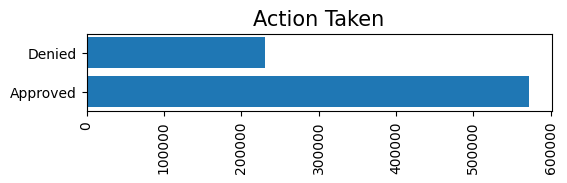

In [14]:
value_counts_bar(df_org.action_taken_description, "Action Taken")

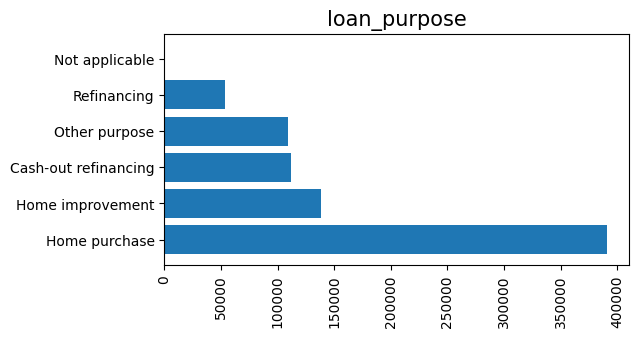

In [15]:
value_counts_bar(df_org.loan_purpose, "loan_purpose")

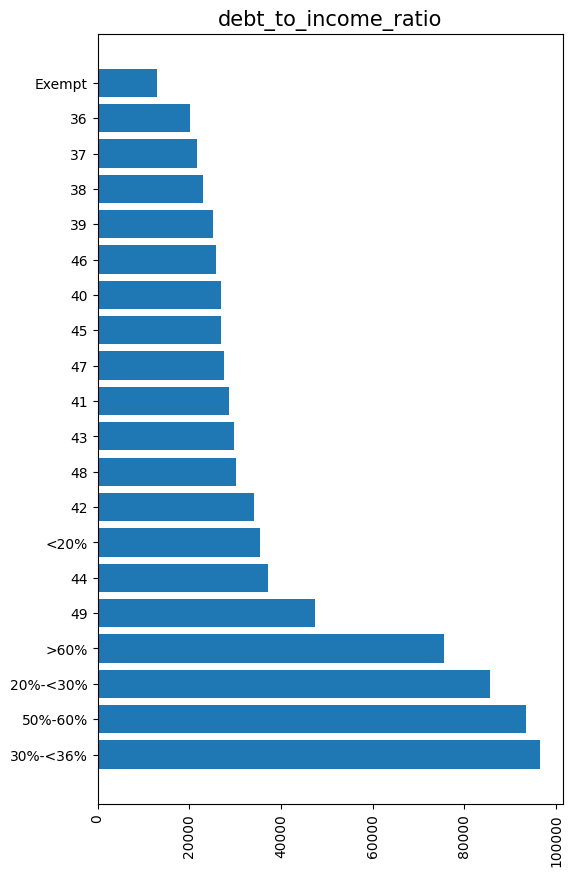

In [16]:
value_counts_bar(df_org.debt_to_income_ratio, "debt_to_income_ratio")

In [17]:
%matplotlib inline

def cate_pie(col, hmda_df, col_action):
    fig, axes = plt.subplots(1, 2, figsize=(20, 20))

    actions = list(hmda_df[col_action].unique())
    indice = np.arange(len(actions))
    for action, i in zip(actions, indice):
        category = hmda_df[hmda_df[col_action]==action][col]
        vc = category.value_counts(sort=False)
        axes[i].pie(vc.values, labels=vc.keys(), autopct='%1.1f%%')
        axes[i].set_title(action, fontsize=14)
        axes[i].axis('equal')

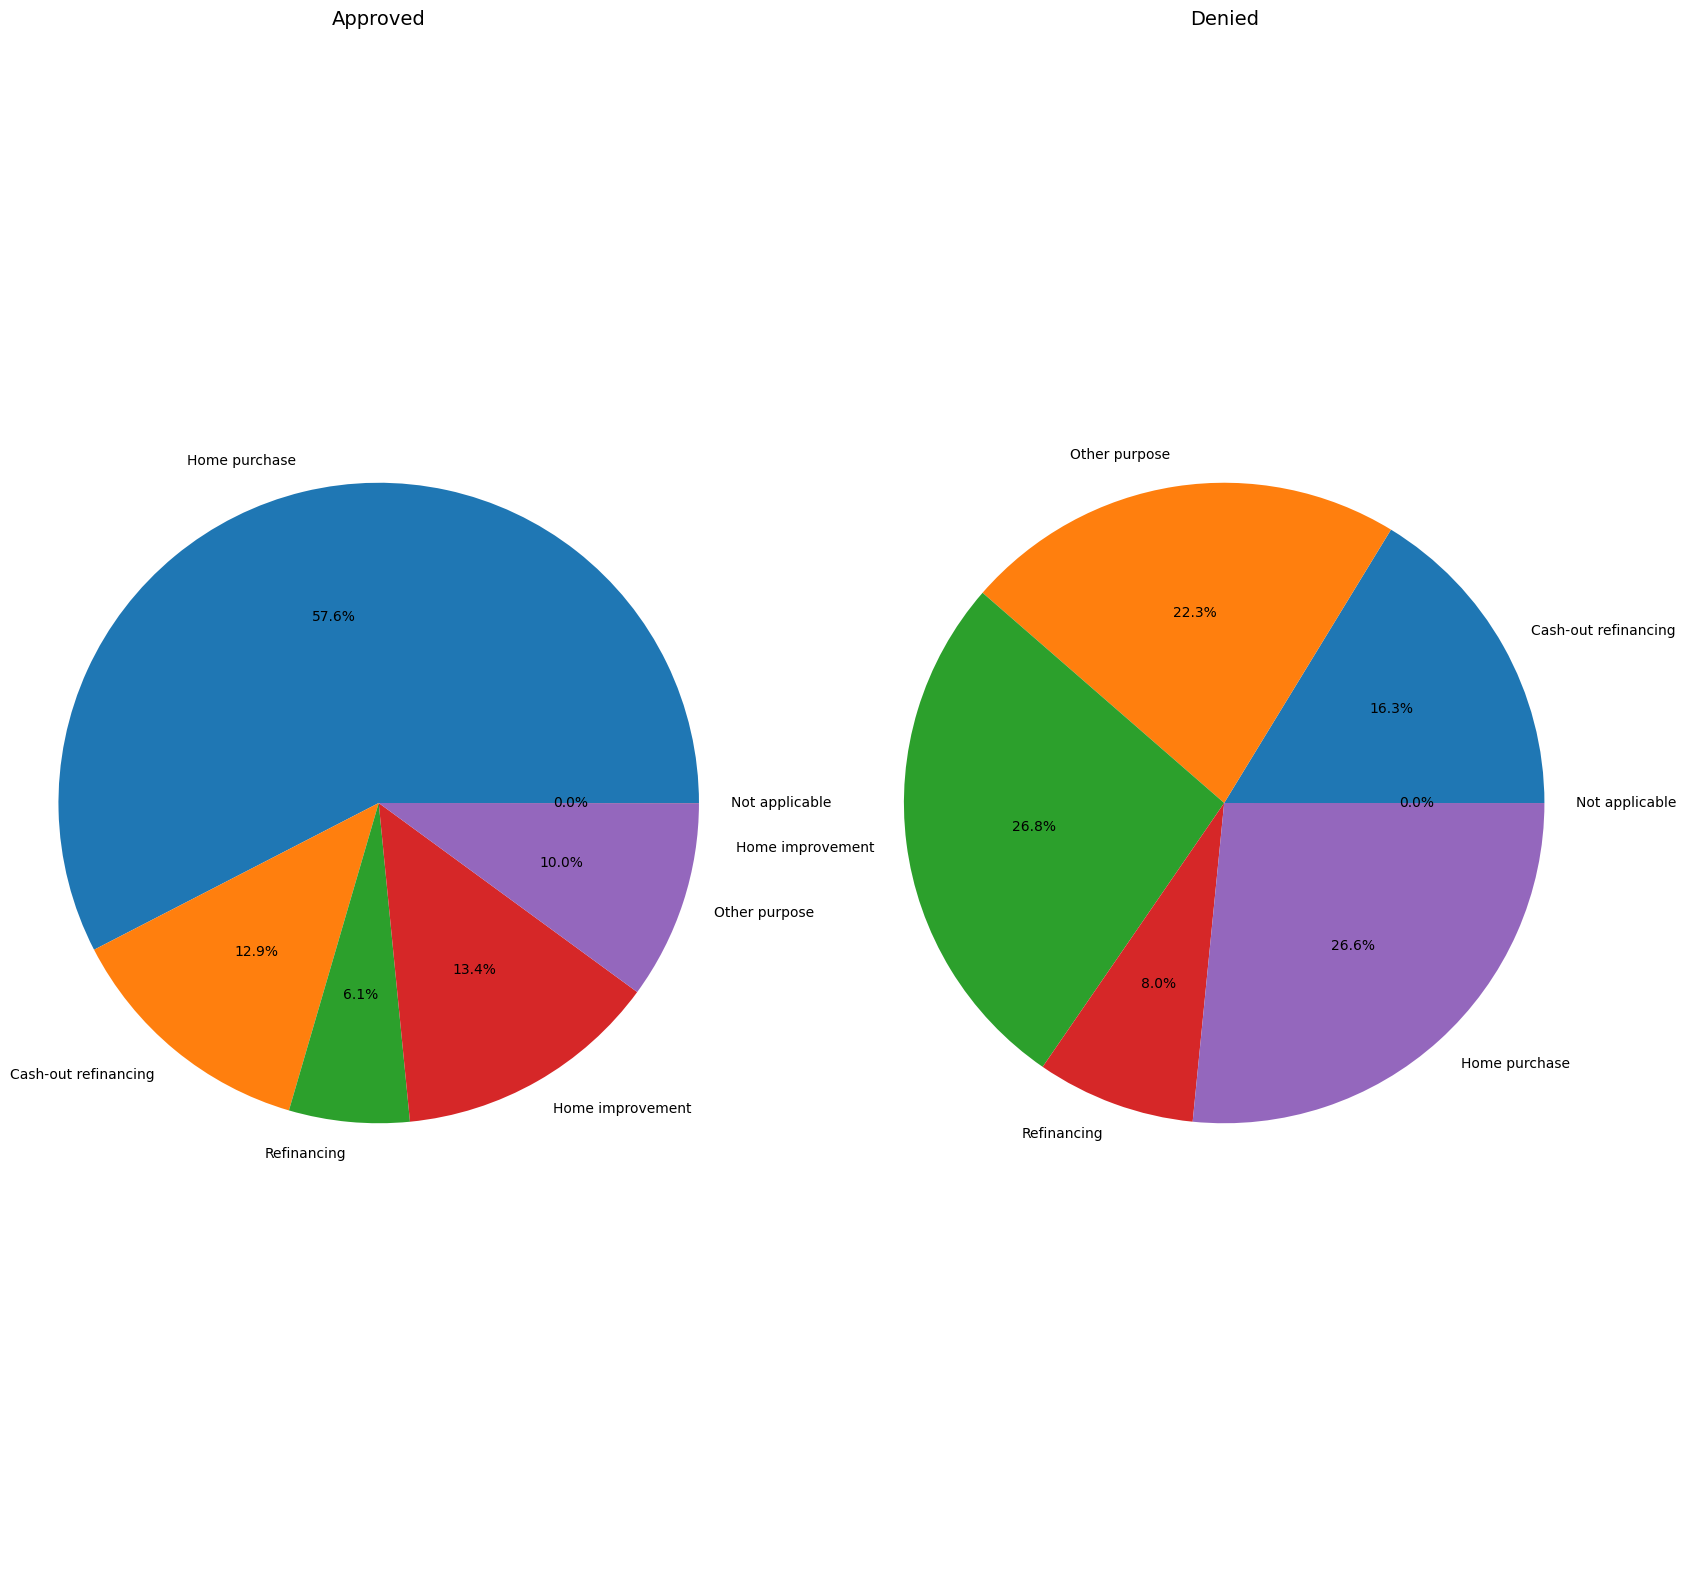

In [18]:
cate_pie("loan_purpose", df_org, 'action_taken_description')

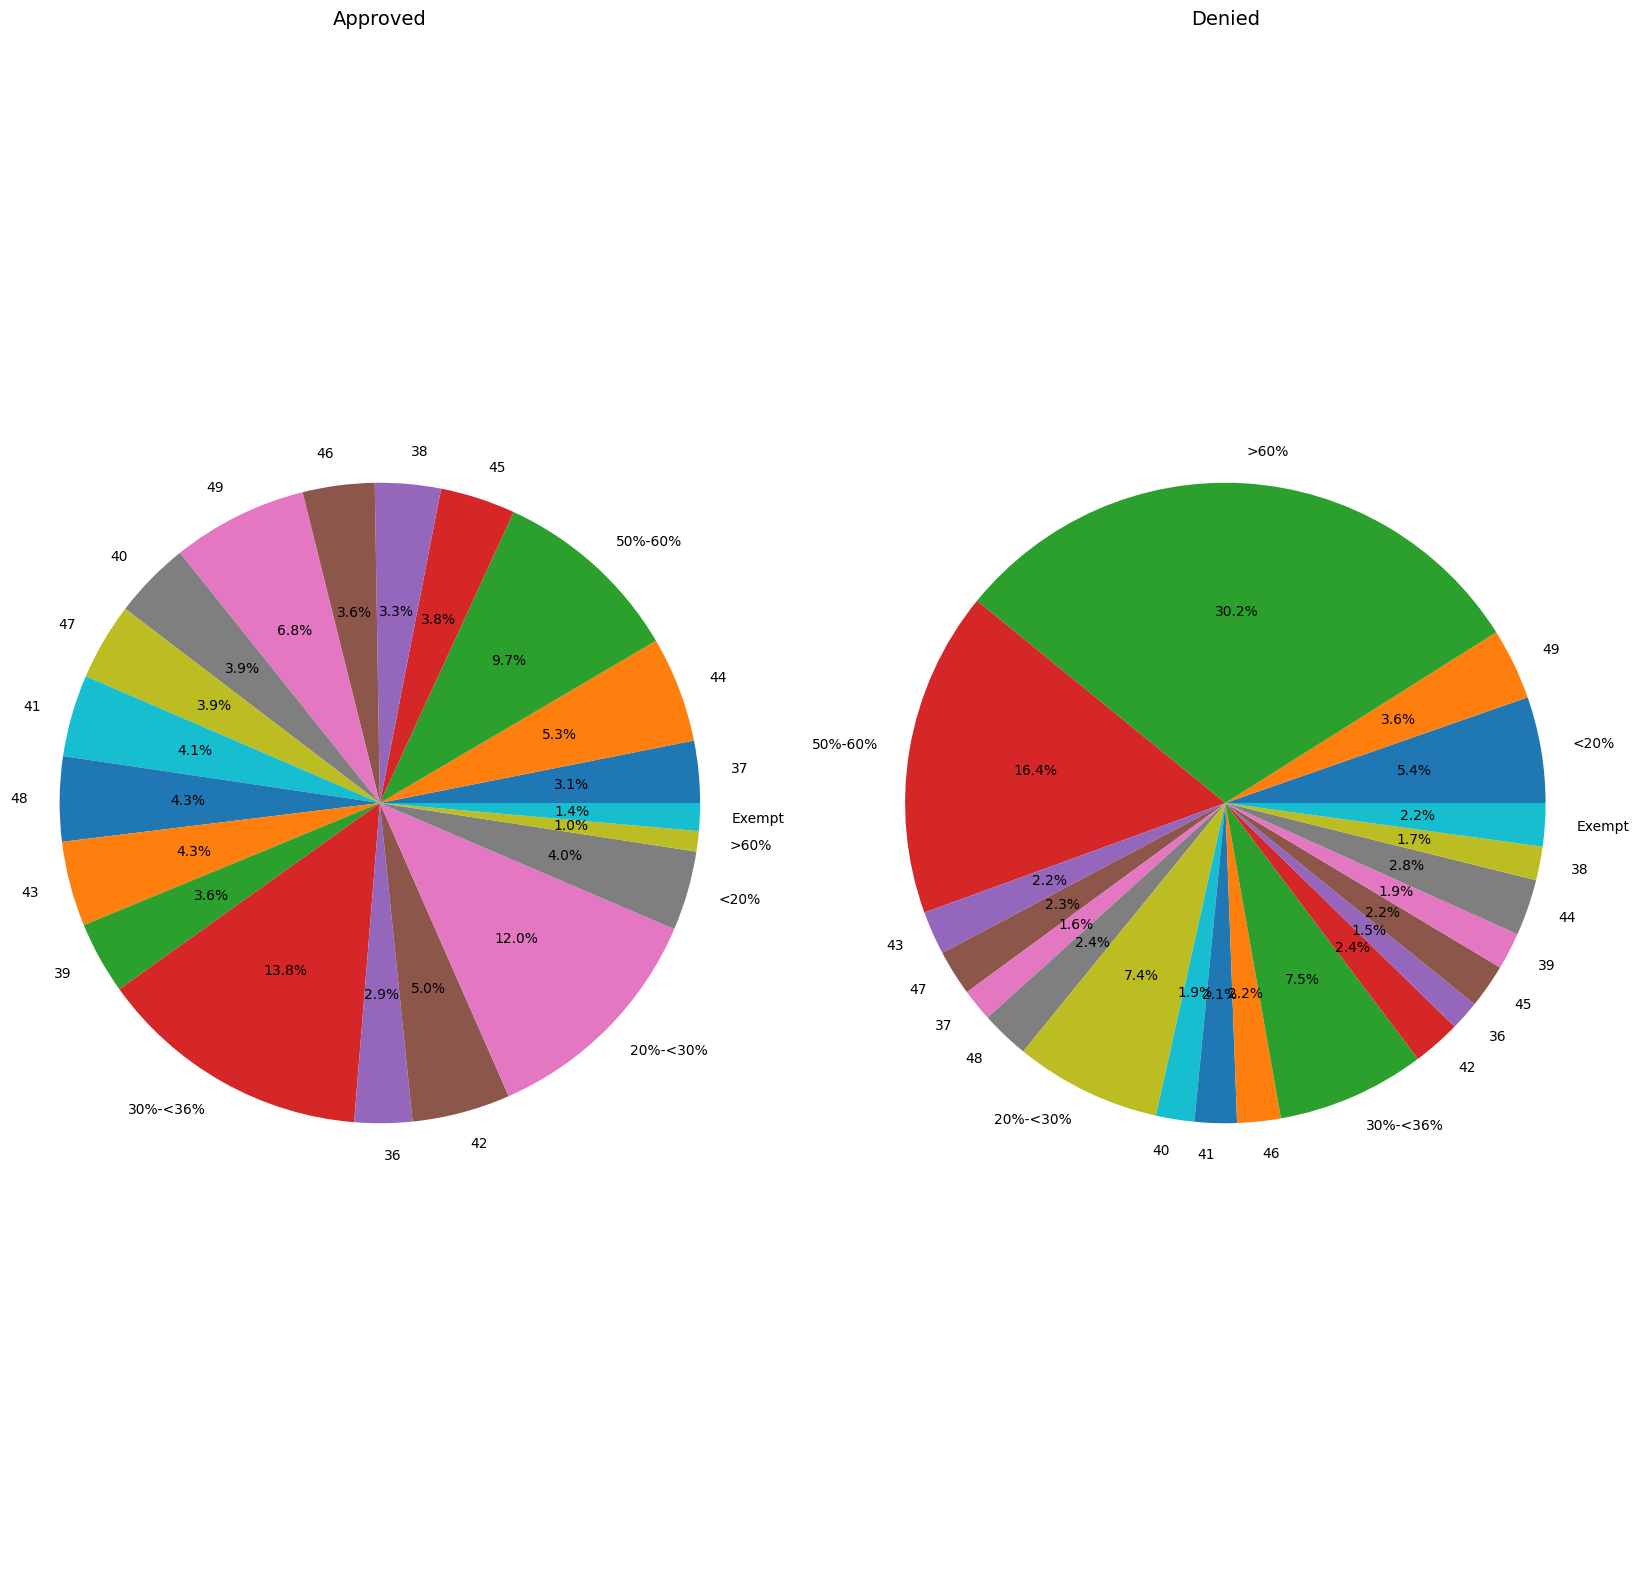

In [19]:
cate_pie("debt_to_income_ratio", df_org, 'action_taken_description')

A debt-to-income (DTI) ratio is a calculation that shows how much of a person's monthly income goes toward paying off debt. 
It's calculated by dividing the total monthly debt payments by the gross monthly income

- DTI tends to be high, implicate that the home loan application tends to be rejected.
- Looking at from the pie chart, 30% home loan application with >60% is rejected 

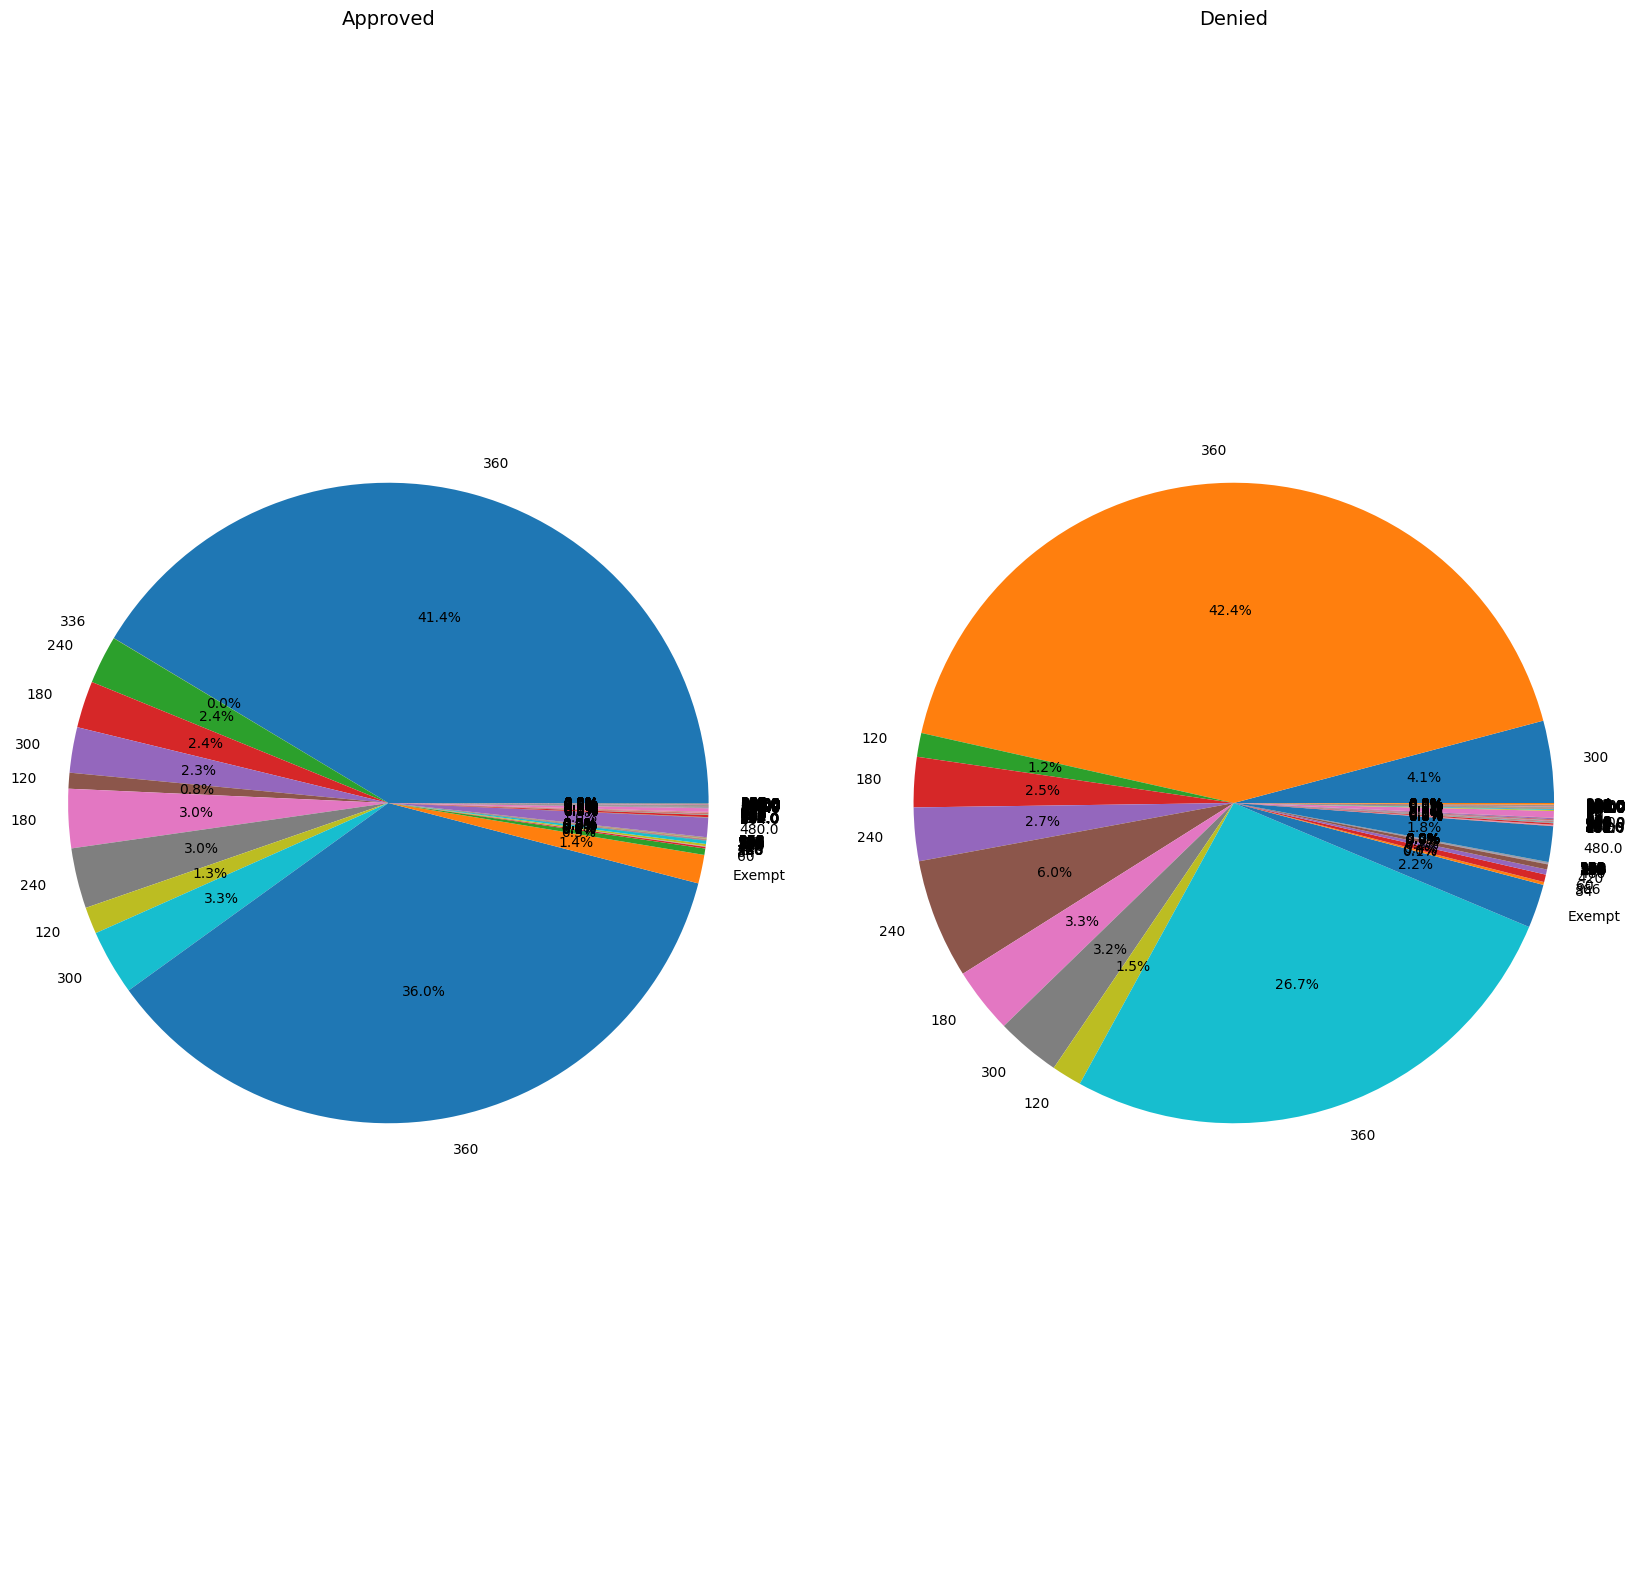

In [20]:
cate_pie("loan_term", df_org, 'action_taken_description')

In [21]:
import warnings

# Suppress warnings related to deprecated features
warnings.filterwarnings("ignore", category=UserWarning)

/home/quochungtran/Desktop/ML_project/LLM_project/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


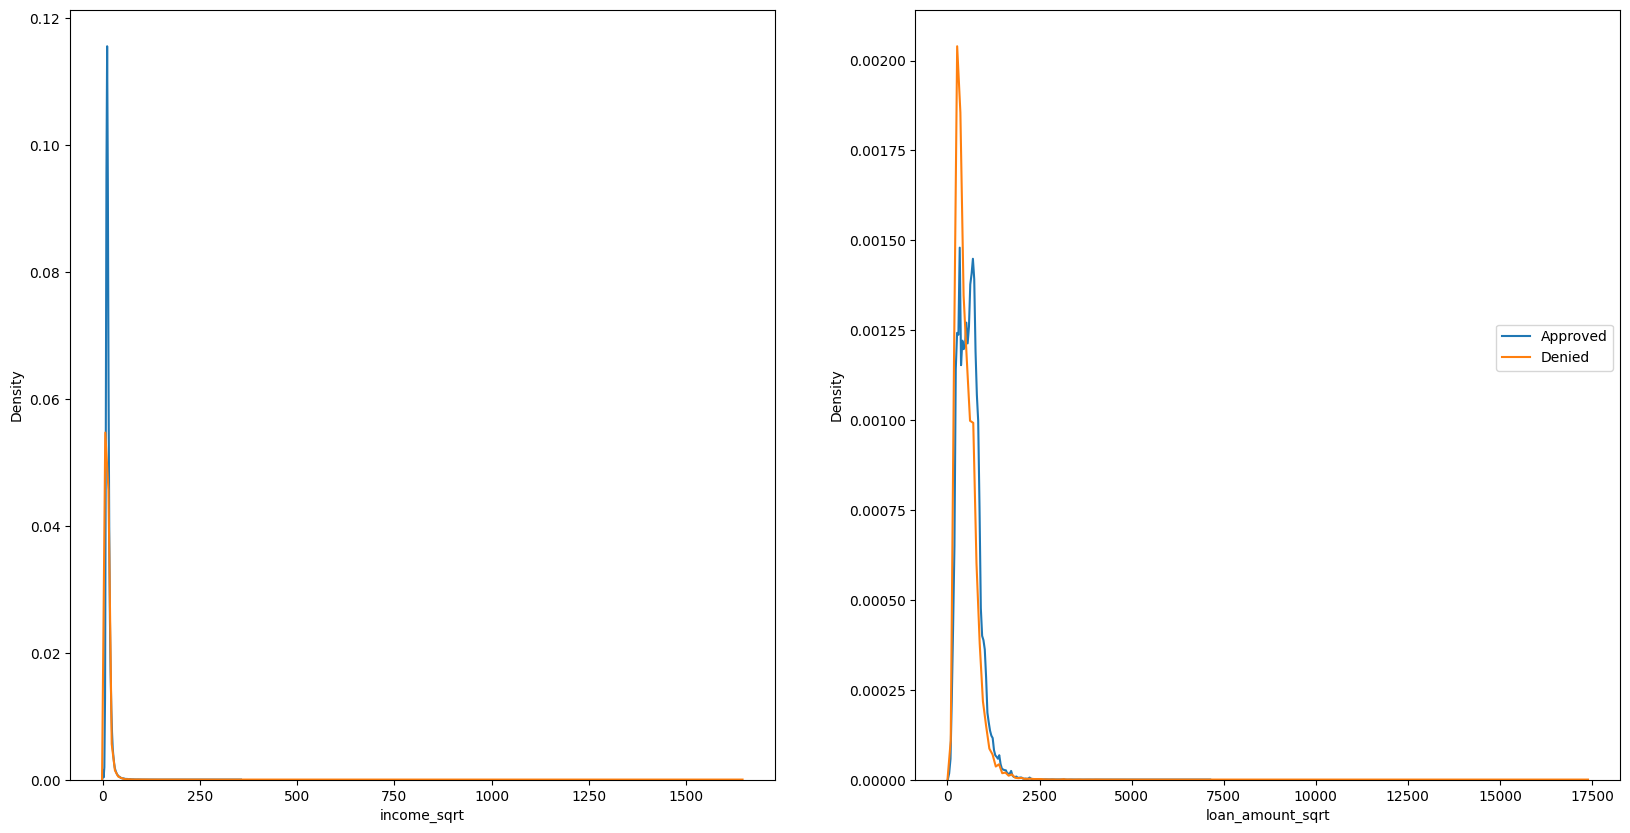

In [22]:
df_sqrt = df_org.copy()
df_sqrt['income_sqrt'] = np.sqrt(df_sqrt['income'])
df_sqrt['loan_amount_sqrt'] = np.sqrt(df_sqrt['loan_amount'])

fig, axes = plt.subplots(1, 2, figsize=(20,10))

for action in df_sqrt['action_taken_description'].unique():
    sns.distplot(df_sqrt[df_sqrt['action_taken_description']==action].income_sqrt,
                 hist=False, kde=True, ax=axes[0])
    sns.distplot(df_sqrt[df_sqrt['action_taken_description']==action].loan_amount_sqrt,
                            hist=False, kde=True, label=action, ax=axes[1])

axes[1].legend(bbox_to_anchor=(1,0.6))
plt.show()

## Modelling


In [23]:
df_org["debt_to_income_ratio"].unique()

array(['37', '44', '50%-60%', '45', '38', '46', '49', '40', '47', '41',
       '48', '43', '39', '30%-<36%', '36', '42', '20%-<30%', '<20%',
       '>60%', 'Exempt'], dtype=object)

In [24]:
df_org.dtypes

income                      float64
debt_to_income_ratio         object
loan_purpose                 object
loan_amount                 float64
loan_term                    object
property_value               object
loan_to_value_ratio          object
action_taken_description     object
dtype: object

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

loan_purpose_mapping = {
        'Home purchase'    : 0,
        'Home improvement' : 1,
        'Refinancing'      : 2,
        'Cash-out refinancing': 3,
        'Other purpose': 4,
        'Not applicable': 5
    }

ordinal_mapping = {
        '<20%': 10, '20%-<30%': 25, '30%-<36%': 33, '36': 36, 
        '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, 
        '42': 42, '43': 43, '44': 44, '45': 45, '46': 46,
        '47': 47, '48': 48, '49': 49, '50%-60%': 55, '>60%': 75.0
    }

def processing_data(df_):
    df_org_preprocess = df_.copy()

    to_convert_numerical_features = ["loan_to_value_ratio", "loan_term", "property_value"]
    for feature in to_convert_numerical_features:
        df_org_preprocess[feature] = pd.to_numeric(df_org_preprocess[feature], errors='coerce')

    df_org_preprocess['loan_purpose_encoded']         = df_org_preprocess['loan_purpose'].map(loan_purpose_mapping)
    df_org_preprocess['debt_to_income_ratio_encoded'] = df_org_preprocess['debt_to_income_ratio'].map(ordinal_mapping)
    df_org_preprocess = df_org_preprocess.dropna()

    return df_org_preprocess


In [27]:
df_preprocessing = processing_data(df_org)

In [28]:
df_preprocessing.dtypes

income                          float64
debt_to_income_ratio             object
loan_purpose                     object
loan_amount                     float64
loan_term                       float64
property_value                  float64
loan_to_value_ratio             float64
action_taken_description         object
loan_purpose_encoded              int64
debt_to_income_ratio_encoded    float64
dtype: object

In [29]:
df_preprocessing

,income,debt_to_income_ratio,loan_purpose,loan_amount,loan_term,property_value,loan_to_value_ratio,action_taken_description,loan_purpose_encoded,debt_to_income_ratio_encoded
771,104.0,37,Home purchase,395000.0,360.0,405000.0,96.500,Approved,0,37.0
772,183.0,44,Home purchase,505000.0,360.0,625000.0,80.000,Approved,0,44.0
774,79.0,50%-60%,Home purchase,255000.0,360.0,265000.0,96.500,Approved,0,55.0
775,94.0,45,Home purchase,385000.0,360.0,425000.0,93.000,Approved,0,45.0
776,138.0,38,Home purchase,415000.0,360.0,475000.0,88.000,Approved,0,38.0
...,...,...,...,...,...,...,...,...,...,...
1337362,83.0,44,Home improvement,505000.0,300.0,695000.0,71.531,Denied,1,44.0
1337363,86.0,41,Home purchase,205000.0,360.0,475000.0,42.110,Approved,0,41.0
1337364,230.0,20%-<30%,Home purchase,355000.0,360.0,855000.0,41.520,Approved,0,25.0
1337365,158.0,30%-<36%,Home purchase,315000.0,360.0,395000.0,80.000,Approved,0,33.0


In [31]:
import joblib

# Define feature set (X) and target variable (y)
features = ['income', 'loan_amount',
                'loan_term', 'property_value', 
                'loan_to_value_ratio', 
                'loan_purpose_encoded',
                'debt_to_income_ratio_encoded']
action_label_encoder = LabelEncoder()

X = df_preprocessing[features]

df_preprocessing['action_taken_encoded'] = action_label_encoder.fit_transform(df_preprocessing['action_taken_description'])
y = df_preprocessing['action_taken_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost classifier
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
# Save the model to a local file
model_filename = "xgboost_model.joblib"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Model saved to xgboost_model.joblib
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89    112823
           1       0.83      0.48      0.61     45195

    accuracy                           0.82    158018
   macro avg       0.83      0.72      0.75    158018
weighted avg       0.82      0.82      0.81    158018

Accuracy Score: 0.8231910288701287


In [32]:
def home_loan_recommandation(home_loan_application_json):
    try:
        app_data = pd.DataFrame([home_loan_application_json])
        app_preprocess_data = processing_data(app_data)
        app_preprocess_data = app_preprocess_data[features]
        # Load the saved model
        loaded_model = joblib.load(model_filename)
        prediction = loaded_model.predict(app_preprocess_data)
        return "Approved" if prediction[0] == 0 else "Rejected"
    except Exception as e:
        return f"Error processing application: {e}"

In [33]:
test_data = {
    "income": 104.0,
    "debt_to_income_ratio": "37",  # Assuming it’s already encoded (ordinal value)
    "loan_amount": 395000.0,
    "loan_term": 360.0,
    "property_value": 405000.0,
    "loan_to_value_ratio": 96.500,
    "loan_purpose": "Home purchase"
}


home_loan_recommandation(test_data)

'Approved'

In [79]:
import pandas as pd

# Add actual labels and predictions to X_test for investigation
X_test['actual_action_taken']    = y_test.values  # Add actual action_taken labels
X_test['predicted_action_taken'] = y_pred         # Add predicted action_taken labels

# Decode predictions and actual labels back to human-readable descriptions
X_test['actual_action_description'] = action_label_encoder.inverse_transform(X_test['actual_action_taken'])
X_test['predicted_action_description'] = action_label_encoder.inverse_transform(X_test['predicted_action_taken'])

# Extract rejected applications based on predictions
rejected_applications = X_test[X_test['predicted_action_description'] == 'Denied']

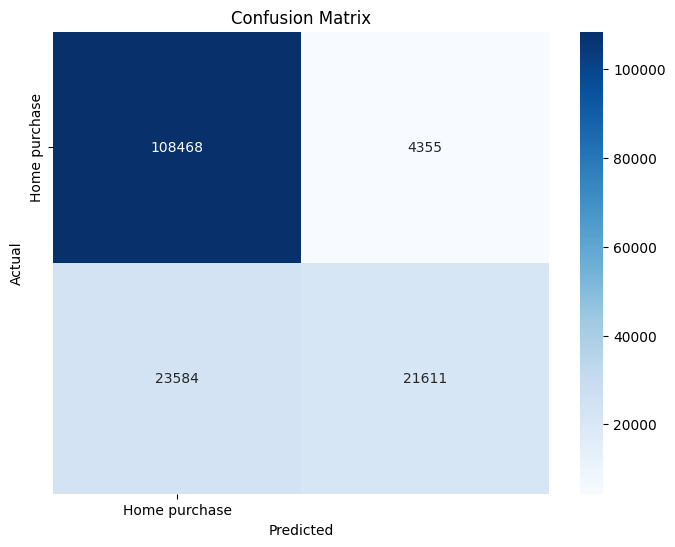

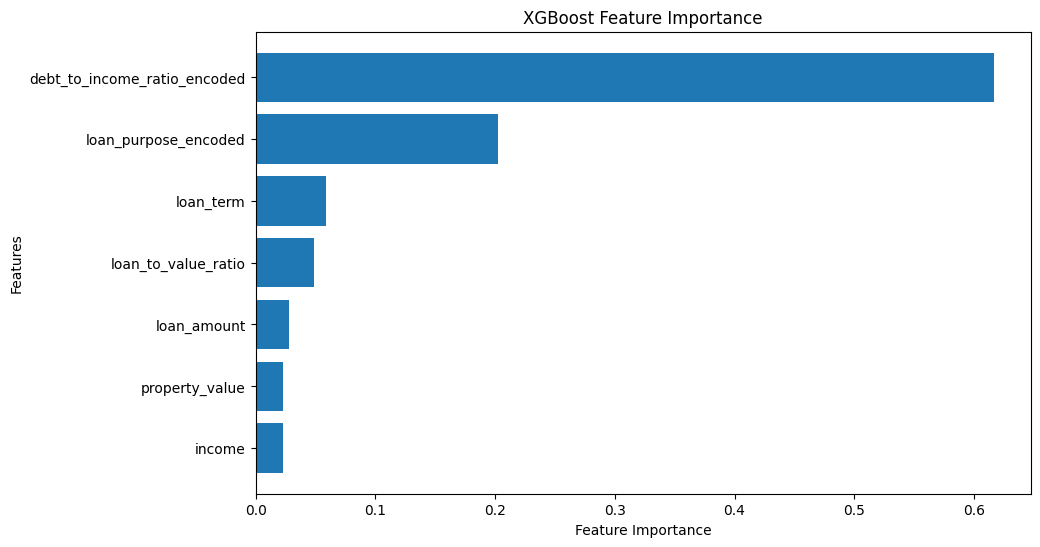

Feature Importance:
                        Feature  Importance
6  debt_to_income_ratio_encoded    0.616542
5          loan_purpose_encoded    0.202749
2                     loan_term    0.058936
4           loan_to_value_ratio    0.048381
1                   loan_amount    0.027605
3                property_value    0.022894
0                        income    0.022894


In [104]:

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Display importance table
print("Feature Importance:")
print(importance_df)


In [37]:
approved_categories = [
    'Loan originated',
    'Application approved but not accepted',
    'Preapproval request approved but not accepted'
]

In [38]:
approved_applications        = df_org[df_org['action_taken_description'].isin(approved_categories)]
loan_originated_applications = df_org[df_org['action_taken_description'].isin(['Loan originated'])]

In [39]:
loan_originated_applications.head()

,income,debt_to_income_ratio,loan_purpose,loan_amount,loan_term,property_value,loan_to_value_ratio,action_taken_description


## Convert rows into Documents for LlamaIndex

In [40]:
import os
from dotenv import load_dotenv
dotenv_path = "../backend/.env"
load_dotenv(dotenv_path=dotenv_path)

True

In [41]:
from langchain.schema import Document

# Function to convert a dataframe row into a LangChain Document
def row_to_document(row):
    """
    Convert a dataframe row into a LLama Document object for Pinecone upload.
    """
    # Combine relevant fields into a single content block
    content = (
        f"Loan Application: \n"
        f"Income: ${row['income']}, Debt-to-Income Ratio: {row['debt_to_income_ratio']}, "
        f"Loan Type: {row['loan_type']}, Loan Purpose: {row['loan_purpose']}, "
        f"Loan Amount: ${row['loan_amount']}, Loan Term: {row['loan_term']} months, "
        f"Property Value: ${row['property_value']}, Loan-to-Value Ratio: {row['loan_to_value_ratio']}%, "
        f"Action Taken: {row['action_taken_description']}."
    )

    summary = (
        "\nSummary:\n"
        f"The applicant has an income of ${row['income']} and is applying for a {row['loan_purpose']} loan of ${row['loan_amount']}.\n"
        f"The loan term is {row['loan_term']} months, and the property value is ${row['property_value']}, resulting in a loan-to-value ratio of {row['loan_to_value_ratio']}%.\n"
        f"The action taken on this application was: {row['action_taken_description']}.\n"
    )
    
    final_text = content + summary

    # Add metadata for filtering and additional context
    metadata = {
        "income": row["income"],
        "debt_to_income_ratio": row["debt_to_income_ratio"],
        "loan_type": row["loan_type"],
        "loan_purpose": row["loan_purpose"],
        "loan_amount": row["loan_amount"],
        "loan_term": row["loan_term"],
        "property_value": row["property_value"],
        "loan_to_value_ratio": row["loan_to_value_ratio"],
        "action_taken_description": row["action_taken_description"],
    }

    return Document(page_content=final_text, metadata=metadata)

# Convert all rows from the DataFrame into LangChain Documents
documents = [row_to_document(row) for _, row in loan_originated_applications.iterrows()]

# Example of a single Document
print("Example Document:")
print(documents[0])


Example Document:


IndexError: list index out of range

In [21]:
print("Number of documents", len(documents))

Number of documents 572706


In [22]:
for doc in documents[0:5]:
    print(doc.page_content)

Loan Application: 
Income: $104.0, Debt-to-Income Ratio: 37, Loan Type: Federal Housing Administration insured (FHA), Loan Purpose: Home purchase, Loan Amount: $395000.0, Loan Term: 360 months, Property Value: $405000.0, Loan-to-Value Ratio: 96.5%, Action Taken: Loan originated.
Summary:
The applicant has an income of $104.0 and is applying for a Home purchase loan of $395000.0.
The loan term is 360 months, and the property value is $405000.0, resulting in a loan-to-value ratio of 96.5%.
The action taken on this application was: Loan originated.

Loan Application: 
Income: $183.0, Debt-to-Income Ratio: 44, Loan Type: Conventional (not insured or guaranteed by FHA, VA, RHS, or FSA), Loan Purpose: Home purchase, Loan Amount: $505000.0, Loan Term: 360 months, Property Value: $625000.0, Loan-to-Value Ratio: 80.0%, Action Taken: Loan originated.
Summary:
The applicant has an income of $183.0 and is applying for a Home purchase loan of $505000.0.
The loan term is 360 months, and the property

## Upload docs to vector database PineCone

In [15]:
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", default=None)

In [16]:
from pinecone import Pinecone, Index, ServerlessSpec
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore


model_embeddings = ["text-embedding-ada-002"]

PINECONE_API_KEY = os.environ["PINECONE_API_KEY"]
pc = Pinecone(api_key=PINECONE_API_KEY)
Pinecone_index_name = "loan-application-records"  # Use lowercase letters and hyphens only
if Pinecone_index_name not in pc.list_indexes().names():
    pc.create_index(
        Pinecone_index_name,
        dimension=1536,
        metric="euclidean",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

pc_index = pc.Index(Pinecone_index_name)

# add docs to vectordb
embeddings = OpenAIEmbeddings(model=model_embeddings[0])

namespace = "loan_app_recommandation"

# is_delete = False
# if (is_delete):
#     pc_index.delete(namespace=namespace, delete_all=True)

PineconeVectorStore.from_documents(
        documents,
        index_name=Pinecone_index_name,
        embedding=embeddings,
        namespace=namespace
    )

print("Successfully uploaded docs to Pinecone vector store")


/home/quochungtran/Desktop/ML_project/LLM_project/.venv/lib/python3.11/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}